In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import random
import seaborn as sns
from sklearn import datasets
from tqdm import tqdm

%matplotlib inline

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1,2"

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchsummary import summary
from torch.autograd import grad

SEED = 999
torch.manual_seed(SEED)

In [4]:
plt.rcParams.update({'font.size': 20})

In [5]:
path = './input/'
os.listdir(path)

[]

In [6]:
Id = 2
N = 10000
SEED = 100


In [7]:
X, Y = datasets.make_moons(n_samples = 2*N)
Q = X[Y==0]
P = X[Y==1]

Q.shape, P.shape

((10000, 2), (10000, 2))

In [8]:
mu_q = Q[:,:2].mean(axis=0)
mu_p = P[:,:2].mean(axis=0)

mu_q, mu_p

(array([-5.77315973e-18,  6.36556105e-01]), array([ 1.        , -0.13655611]))

In [9]:
Q.shape, P.shape

((10000, 2), (10000, 2))

In [10]:
x = torch.FloatTensor(P[:3]).cuda()
y = torch.FloatTensor(Q[:3]).cuda()
x.shape, y.shape

(torch.Size([3, 2]), torch.Size([3, 2]))

In [11]:
class Ki(nn.Module):
    def __init__(self, features = 128):
        super(Ki, self).__init__()
        
        self.W0b0 = nn.Linear(in_features=Id, out_features=features)
        
        self.W1b1 = nn.Linear(in_features=features, out_features=features)
        
        self.W2b2 = nn.Linear(in_features=features, out_features=features)
        
        self.W3b3 = nn.Linear(in_features=features, out_features=Id)
        
        
    def forward(self, x):
        x = F.leaky_relu(self.W0b0(x))
        x = F.leaky_relu(self.W1b1(x))
        x = F.leaky_relu(self.W2b2(x))
        op = self.W3b3(x)
        
        return op
        

In [12]:
ki = Ki().cuda()
summary(ki,(1,Id))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 128]             384
            Linear-2               [-1, 1, 128]          16,512
            Linear-3               [-1, 1, 128]          16,512
            Linear-4                 [-1, 1, 2]             258
Total params: 33,666
Trainable params: 33,666
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.13
Estimated Total Size (MB): 0.13
----------------------------------------------------------------


In [13]:
class Psi(nn.Module):
    def __init__(self, features = 128):
        super(Psi, self).__init__()
        
        self.W0b0 = nn.Linear(in_features=Id, out_features=features)
        
        self.W1b1 = nn.Linear(in_features=features, out_features=features)
        
        self.W2b2 = nn.Linear(in_features=features, out_features=features)
        
        self.W3b3 = nn.Linear(in_features=features, out_features=1)
        
        
    def forward(self, x):
        x = F.leaky_relu(self.W0b0(x))
        x = F.leaky_relu(self.W1b1(x))
        x = F.leaky_relu(self.W2b2(x))
        op = self.W3b3(x)
        
        return op
        

In [14]:
psi = Psi().cuda()
summary(psi,(1,Id))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 128]             384
            Linear-2               [-1, 1, 128]          16,512
            Linear-3               [-1, 1, 128]          16,512
            Linear-4                 [-1, 1, 1]             129
Total params: 33,537
Trainable params: 33,537
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.13
Estimated Total Size (MB): 0.13
----------------------------------------------------------------


In [15]:
def PushForward(ki,x):
    gradPhi = ki(x)
    return gradPhi

In [16]:
def GradientPenalty(psi, ki, x, y):
    batch_size = x.shape[0]
    ip1 = nn.Parameter(x, requires_grad = True)
    ip2 = torch.mean(ki(ip1))
    
    eta =torch.rand(1).cuda()
    ip = nn.Parameter((eta*y+(1-eta)*ip2), requires_grad=True)
    op = torch.mean(psi(ip))
    
    # compute gradient penalty
    gp = torch.norm(grad(op, ip, create_graph=True)[0]*batch_size, 'fro', dim=1)
    gp = torch.mean((gp-1)**2)
    
    return gp

gp = GradientPenalty(psi, ki, x, y)
gp

tensor(0.9317, device='cuda:0', grad_fn=<MeanBackward0>)

In [17]:
def WassersteinLoss(psi,ki,x,y):
    yp = PushForward(ki,x)
    dot = torch.mean(x*yp, dim=1).unsqueeze(dim=1)
    
    loss = (psi(y) + dot - psi(yp)).mean()
    return loss

loss = WassersteinLoss(psi,ki,x,y)
loss

tensor(-0.0190, device='cuda:0', grad_fn=<MeanBackward0>)

In [18]:
T = 10001
M = 128
K_ki = 16
lam_gp =1.

parallel = True

In [19]:
psi = Psi()
ki = Ki()

if parallel:
    psi = nn.DataParallel(psi, [0,1])
    ki = nn.DataParallel(ki, [0,1])

psi.cuda()
ki.cuda()


DataParallel(
  (module): Ki(
    (W0b0): Linear(in_features=2, out_features=128, bias=True)
    (W1b1): Linear(in_features=128, out_features=128, bias=True)
    (W2b2): Linear(in_features=128, out_features=128, bias=True)
    (W3b3): Linear(in_features=128, out_features=2, bias=True)
  )
)

In [20]:
Ki_opt = optim.Adam(ki.parameters(), betas=(0.5,0.99), lr = 1e-3)
Psi_opt = optim.Adam(psi.parameters(), betas=(0.5,0.99), lr = 1e-3)

In [21]:
%%time
psi_l = []
ki_l = []
Gp_l = []

for t in tqdm(range(T)):
    y_idxs = random.sample(range(0,P.shape[0]), M)
    y_batch = torch.FloatTensor(P[y_idxs]).cuda()
    
    ## Multiple infimum updates to restrict exploding loss
    x_idxs = random.sample(range(0,Q.shape[0]), M)
    x_batch = torch.FloatTensor(Q[x_idxs]).cuda()

    ##########################################################
    ## Outer minimization loop
    ##########################################################       
    ## Fix Ki and update Psi to compute infimum. 
    for param in psi.parameters():
        param.requires_grad = True
    for param in ki.parameters():
        param.requires_grad = False

    gp_loss = GradientPenalty(psi, ki, x_batch, y_batch)
    Psi_loss = WassersteinLoss(psi, ki, x_batch, y_batch) + lam_gp * gp_loss

    Psi_opt.zero_grad()
    Psi_loss.backward(retain_graph=True)
    Psi_opt.step()


    psi_l.append(Psi_loss.item())
    Gp_l.append(gp_loss.item())

    ##########################################################
    ## Inner maximization loop: update once for every C updates
    ##########################################################
    ki_l_ = []
    for _ in range(K_ki):
        idxs = random.sample(range(0,P.shape[0]), M)
        y_batch = torch.FloatTensor(P[idxs]).cuda()
        x_batch = torch.FloatTensor(Q[idxs]).cuda()

        # print('Data: ', x_batch.shape, y_batch.shape)

        # sys.exit()
        ## Fix Psi and update Ki to compute convex conjugate/ supremum 
        for param in psi.parameters():
            param.requires_grad = False
        for param in ki.parameters():
            param.requires_grad = True

        Ki_loss = - WassersteinLoss(psi, ki, x_batch, y_batch) 

        Ki_opt.zero_grad()
        Ki_loss.backward(retain_graph=True)
        Ki_opt.step()

        ki_l_.append(Ki_loss.item())
    ki_l.append(np.asarray(ki_l_).mean())
        
    if t%100==0:
        print("Epoch: ", t,"|",T, "\t psi loss: ", np.round(psi_l[-1],3),"\t Gp loss: ",np.round(Gp_l[-1],2), "\t ki loss: ", np.round(ki_l[-1],2)) 
        
        

  0%|          | 1/10001 [00:05<15:43:24,  5.66s/it]

Epoch:  0 | 10001 	 psi loss:  0.923 	 Gp loss:  0.9 	 ki loss:  -0.52


  1%|          | 101/10001 [00:28<37:19,  4.42it/s] 

Epoch:  100 | 10001 	 psi loss:  0.496 	 Gp loss:  0.11 	 ki loss:  0.02


  2%|▏         | 201/10001 [00:50<37:38,  4.34it/s]

Epoch:  200 | 10001 	 psi loss:  0.467 	 Gp loss:  0.17 	 ki loss:  -0.26


  3%|▎         | 301/10001 [01:13<36:16,  4.46it/s]

Epoch:  300 | 10001 	 psi loss:  0.301 	 Gp loss:  0.06 	 ki loss:  -0.22


  4%|▍         | 401/10001 [01:36<35:30,  4.51it/s]

Epoch:  400 | 10001 	 psi loss:  0.493 	 Gp loss:  0.24 	 ki loss:  -0.21


  5%|▌         | 501/10001 [01:59<36:29,  4.34it/s]

Epoch:  500 | 10001 	 psi loss:  0.49 	 Gp loss:  0.24 	 ki loss:  -0.22


  6%|▌         | 601/10001 [02:27<45:15,  3.46it/s]

Epoch:  600 | 10001 	 psi loss:  0.21 	 Gp loss:  0.01 	 ki loss:  -0.21


  7%|▋         | 701/10001 [02:57<47:07,  3.29it/s]

Epoch:  700 | 10001 	 psi loss:  0.236 	 Gp loss:  0.03 	 ki loss:  -0.23


  8%|▊         | 801/10001 [03:26<44:15,  3.46it/s]

Epoch:  800 | 10001 	 psi loss:  0.293 	 Gp loss:  0.1 	 ki loss:  -0.2


  9%|▉         | 901/10001 [03:56<46:32,  3.26it/s]

Epoch:  900 | 10001 	 psi loss:  0.319 	 Gp loss:  0.13 	 ki loss:  -0.18


 10%|█         | 1001/10001 [04:25<44:06,  3.40it/s]

Epoch:  1000 | 10001 	 psi loss:  0.405 	 Gp loss:  0.14 	 ki loss:  -0.2


 11%|█         | 1101/10001 [04:52<42:28,  3.49it/s]

Epoch:  1100 | 10001 	 psi loss:  0.209 	 Gp loss:  0.0 	 ki loss:  -0.22


 12%|█▏        | 1201/10001 [05:21<41:35,  3.53it/s]

Epoch:  1200 | 10001 	 psi loss:  0.271 	 Gp loss:  0.03 	 ki loss:  -0.21


 13%|█▎        | 1301/10001 [05:50<42:13,  3.43it/s]

Epoch:  1300 | 10001 	 psi loss:  0.279 	 Gp loss:  0.0 	 ki loss:  -0.21


 14%|█▍        | 1401/10001 [06:20<41:46,  3.43it/s]

Epoch:  1400 | 10001 	 psi loss:  0.217 	 Gp loss:  0.01 	 ki loss:  -0.2


 15%|█▌        | 1501/10001 [06:49<42:27,  3.34it/s]

Epoch:  1500 | 10001 	 psi loss:  0.157 	 Gp loss:  0.0 	 ki loss:  -0.19


 16%|█▌        | 1601/10001 [07:16<41:28,  3.38it/s]

Epoch:  1600 | 10001 	 psi loss:  0.416 	 Gp loss:  0.22 	 ki loss:  -0.19


 17%|█▋        | 1701/10001 [07:45<40:19,  3.43it/s]

Epoch:  1700 | 10001 	 psi loss:  0.23 	 Gp loss:  0.02 	 ki loss:  -0.21


 18%|█▊        | 1801/10001 [08:15<40:03,  3.41it/s]

Epoch:  1800 | 10001 	 psi loss:  0.38 	 Gp loss:  0.15 	 ki loss:  -0.2


 19%|█▉        | 1901/10001 [08:45<40:36,  3.32it/s]

Epoch:  1900 | 10001 	 psi loss:  0.432 	 Gp loss:  0.21 	 ki loss:  -0.17


 20%|██        | 2001/10001 [09:14<39:03,  3.41it/s]

Epoch:  2000 | 10001 	 psi loss:  0.201 	 Gp loss:  0.03 	 ki loss:  -0.2


 21%|██        | 2102/10001 [09:41<24:52,  5.29it/s]

Epoch:  2100 | 10001 	 psi loss:  0.219 	 Gp loss:  0.08 	 ki loss:  -0.2


 22%|██▏       | 2201/10001 [10:04<38:09,  3.41it/s]

Epoch:  2200 | 10001 	 psi loss:  0.226 	 Gp loss:  0.01 	 ki loss:  -0.21


 23%|██▎       | 2301/10001 [10:33<39:18,  3.26it/s]

Epoch:  2300 | 10001 	 psi loss:  0.436 	 Gp loss:  0.27 	 ki loss:  -0.21


 24%|██▍       | 2401/10001 [11:03<38:06,  3.32it/s]

Epoch:  2400 | 10001 	 psi loss:  0.239 	 Gp loss:  0.01 	 ki loss:  -0.17


 25%|██▌       | 2501/10001 [11:32<35:32,  3.52it/s]

Epoch:  2500 | 10001 	 psi loss:  0.215 	 Gp loss:  0.02 	 ki loss:  -0.2


 26%|██▌       | 2601/10001 [12:02<36:12,  3.41it/s]

Epoch:  2600 | 10001 	 psi loss:  0.232 	 Gp loss:  0.01 	 ki loss:  -0.19


 27%|██▋       | 2701/10001 [12:31<35:53,  3.39it/s]

Epoch:  2700 | 10001 	 psi loss:  0.227 	 Gp loss:  0.01 	 ki loss:  -0.19


 28%|██▊       | 2801/10001 [12:59<35:22,  3.39it/s]

Epoch:  2800 | 10001 	 psi loss:  0.231 	 Gp loss:  0.0 	 ki loss:  -0.18


 29%|██▉       | 2901/10001 [13:28<36:02,  3.28it/s]

Epoch:  2900 | 10001 	 psi loss:  0.155 	 Gp loss:  0.02 	 ki loss:  -0.2


 30%|███       | 3001/10001 [13:56<33:06,  3.52it/s]

Epoch:  3000 | 10001 	 psi loss:  0.218 	 Gp loss:  0.01 	 ki loss:  -0.21


 31%|███       | 3101/10001 [14:26<34:17,  3.35it/s]

Epoch:  3100 | 10001 	 psi loss:  0.26 	 Gp loss:  0.01 	 ki loss:  -0.2


 32%|███▏      | 3201/10001 [14:56<33:12,  3.41it/s]

Epoch:  3200 | 10001 	 psi loss:  0.463 	 Gp loss:  0.18 	 ki loss:  -0.21


 33%|███▎      | 3301/10001 [15:25<33:08,  3.37it/s]

Epoch:  3300 | 10001 	 psi loss:  0.245 	 Gp loss:  0.01 	 ki loss:  -0.2


 34%|███▍      | 3401/10001 [15:55<31:41,  3.47it/s]

Epoch:  3400 | 10001 	 psi loss:  0.204 	 Gp loss:  0.01 	 ki loss:  -0.21


 35%|███▌      | 3501/10001 [16:24<32:56,  3.29it/s]

Epoch:  3500 | 10001 	 psi loss:  0.223 	 Gp loss:  0.0 	 ki loss:  -0.19


 36%|███▌      | 3601/10001 [16:53<31:41,  3.37it/s]

Epoch:  3600 | 10001 	 psi loss:  0.283 	 Gp loss:  0.08 	 ki loss:  -0.2


 37%|███▋      | 3701/10001 [17:23<30:50,  3.41it/s]

Epoch:  3700 | 10001 	 psi loss:  0.195 	 Gp loss:  0.01 	 ki loss:  -0.2


 38%|███▊      | 3801/10001 [17:52<30:02,  3.44it/s]

Epoch:  3800 | 10001 	 psi loss:  0.265 	 Gp loss:  0.13 	 ki loss:  -0.19


 39%|███▉      | 3901/10001 [18:21<28:42,  3.54it/s]

Epoch:  3900 | 10001 	 psi loss:  0.197 	 Gp loss:  0.0 	 ki loss:  -0.2


 40%|████      | 4001/10001 [18:50<28:18,  3.53it/s]

Epoch:  4000 | 10001 	 psi loss:  0.209 	 Gp loss:  0.0 	 ki loss:  -0.21


 41%|████      | 4101/10001 [19:20<28:24,  3.46it/s]

Epoch:  4100 | 10001 	 psi loss:  0.154 	 Gp loss:  0.0 	 ki loss:  -0.21


 42%|████▏     | 4202/10001 [19:48<18:17,  5.29it/s]

Epoch:  4200 | 10001 	 psi loss:  0.192 	 Gp loss:  0.0 	 ki loss:  -0.21


 43%|████▎     | 4301/10001 [20:10<29:15,  3.25it/s]

Epoch:  4300 | 10001 	 psi loss:  0.238 	 Gp loss:  0.0 	 ki loss:  -0.2


 44%|████▍     | 4401/10001 [20:39<28:02,  3.33it/s]

Epoch:  4400 | 10001 	 psi loss:  0.202 	 Gp loss:  0.0 	 ki loss:  -0.2


 45%|████▌     | 4501/10001 [21:05<25:27,  3.60it/s]

Epoch:  4500 | 10001 	 psi loss:  0.209 	 Gp loss:  0.0 	 ki loss:  -0.19


 46%|████▌     | 4601/10001 [21:34<27:21,  3.29it/s]

Epoch:  4600 | 10001 	 psi loss:  0.231 	 Gp loss:  0.02 	 ki loss:  -0.2


 47%|████▋     | 4701/10001 [22:04<26:53,  3.28it/s]

Epoch:  4700 | 10001 	 psi loss:  0.151 	 Gp loss:  0.0 	 ki loss:  -0.2


 48%|████▊     | 4801/10001 [22:33<25:47,  3.36it/s]

Epoch:  4800 | 10001 	 psi loss:  0.261 	 Gp loss:  0.07 	 ki loss:  -0.22


 49%|████▉     | 4901/10001 [23:03<25:39,  3.31it/s]

Epoch:  4900 | 10001 	 psi loss:  0.205 	 Gp loss:  0.0 	 ki loss:  -0.18


 50%|█████     | 5001/10001 [23:32<25:24,  3.28it/s]

Epoch:  5000 | 10001 	 psi loss:  0.211 	 Gp loss:  0.0 	 ki loss:  -0.18


 51%|█████     | 5101/10001 [24:02<23:49,  3.43it/s]

Epoch:  5100 | 10001 	 psi loss:  0.231 	 Gp loss:  0.02 	 ki loss:  -0.18


 52%|█████▏    | 5201/10001 [24:32<23:01,  3.48it/s]

Epoch:  5200 | 10001 	 psi loss:  0.174 	 Gp loss:  0.05 	 ki loss:  -0.19


 53%|█████▎    | 5301/10001 [25:01<23:58,  3.27it/s]

Epoch:  5300 | 10001 	 psi loss:  0.171 	 Gp loss:  0.0 	 ki loss:  -0.18


 54%|█████▍    | 5401/10001 [25:31<22:02,  3.48it/s]

Epoch:  5400 | 10001 	 psi loss:  0.157 	 Gp loss:  0.0 	 ki loss:  -0.19


 55%|█████▌    | 5501/10001 [26:00<22:52,  3.28it/s]

Epoch:  5500 | 10001 	 psi loss:  0.211 	 Gp loss:  0.0 	 ki loss:  -0.19


 56%|█████▌    | 5601/10001 [26:30<21:34,  3.40it/s]

Epoch:  5600 | 10001 	 psi loss:  0.21 	 Gp loss:  0.0 	 ki loss:  -0.19


 57%|█████▋    | 5701/10001 [26:59<21:09,  3.39it/s]

Epoch:  5700 | 10001 	 psi loss:  0.182 	 Gp loss:  0.0 	 ki loss:  -0.2


 58%|█████▊    | 5802/10001 [27:28<14:03,  4.98it/s]

Epoch:  5800 | 10001 	 psi loss:  0.156 	 Gp loss:  0.0 	 ki loss:  -0.18


 59%|█████▉    | 5901/10001 [27:57<20:20,  3.36it/s]

Epoch:  5900 | 10001 	 psi loss:  0.231 	 Gp loss:  0.0 	 ki loss:  -0.17


 60%|██████    | 6001/10001 [28:26<21:05,  3.16it/s]

Epoch:  6000 | 10001 	 psi loss:  0.218 	 Gp loss:  0.0 	 ki loss:  -0.18


 61%|██████    | 6101/10001 [28:56<19:57,  3.26it/s]

Epoch:  6100 | 10001 	 psi loss:  0.218 	 Gp loss:  0.0 	 ki loss:  -0.19


 62%|██████▏   | 6201/10001 [29:23<17:56,  3.53it/s]

Epoch:  6200 | 10001 	 psi loss:  0.148 	 Gp loss:  0.0 	 ki loss:  -0.19


 63%|██████▎   | 6301/10001 [29:52<17:06,  3.60it/s]

Epoch:  6300 | 10001 	 psi loss:  0.205 	 Gp loss:  0.0 	 ki loss:  -0.19


 64%|██████▍   | 6401/10001 [30:13<17:12,  3.49it/s]

Epoch:  6400 | 10001 	 psi loss:  0.18 	 Gp loss:  0.0 	 ki loss:  -0.2


 65%|██████▌   | 6501/10001 [30:43<17:06,  3.41it/s]

Epoch:  6500 | 10001 	 psi loss:  0.265 	 Gp loss:  0.0 	 ki loss:  -0.19


 66%|██████▌   | 6601/10001 [31:13<17:31,  3.23it/s]

Epoch:  6600 | 10001 	 psi loss:  0.196 	 Gp loss:  0.0 	 ki loss:  -0.21


 67%|██████▋   | 6701/10001 [31:43<16:16,  3.38it/s]

Epoch:  6700 | 10001 	 psi loss:  0.201 	 Gp loss:  0.0 	 ki loss:  -0.2


 68%|██████▊   | 6801/10001 [32:12<15:31,  3.44it/s]

Epoch:  6800 | 10001 	 psi loss:  0.17 	 Gp loss:  0.0 	 ki loss:  -0.19


 69%|██████▉   | 6901/10001 [32:41<14:13,  3.63it/s]

Epoch:  6900 | 10001 	 psi loss:  0.112 	 Gp loss:  0.0 	 ki loss:  -0.17


 70%|███████   | 7001/10001 [33:11<14:52,  3.36it/s]

Epoch:  7000 | 10001 	 psi loss:  0.16 	 Gp loss:  0.0 	 ki loss:  -0.2


 71%|███████   | 7101/10001 [33:41<14:15,  3.39it/s]

Epoch:  7100 | 10001 	 psi loss:  0.189 	 Gp loss:  0.0 	 ki loss:  -0.19


 72%|███████▏  | 7201/10001 [34:10<14:05,  3.31it/s]

Epoch:  7200 | 10001 	 psi loss:  0.218 	 Gp loss:  0.01 	 ki loss:  -0.2


 73%|███████▎  | 7301/10001 [34:38<13:44,  3.28it/s]

Epoch:  7300 | 10001 	 psi loss:  0.213 	 Gp loss:  0.0 	 ki loss:  -0.2


 74%|███████▍  | 7401/10001 [35:07<12:39,  3.42it/s]

Epoch:  7400 | 10001 	 psi loss:  0.222 	 Gp loss:  0.01 	 ki loss:  -0.2


 75%|███████▌  | 7501/10001 [35:36<12:18,  3.39it/s]

Epoch:  7500 | 10001 	 psi loss:  0.226 	 Gp loss:  0.0 	 ki loss:  -0.19


 76%|███████▌  | 7601/10001 [36:06<11:46,  3.40it/s]

Epoch:  7600 | 10001 	 psi loss:  0.327 	 Gp loss:  0.11 	 ki loss:  -0.19


 77%|███████▋  | 7701/10001 [36:35<11:15,  3.40it/s]

Epoch:  7700 | 10001 	 psi loss:  0.178 	 Gp loss:  0.0 	 ki loss:  -0.19


 78%|███████▊  | 7801/10001 [37:05<10:25,  3.52it/s]

Epoch:  7800 | 10001 	 psi loss:  0.273 	 Gp loss:  0.0 	 ki loss:  -0.18


 79%|███████▉  | 7901/10001 [37:33<09:44,  3.59it/s]

Epoch:  7900 | 10001 	 psi loss:  0.188 	 Gp loss:  0.0 	 ki loss:  -0.18


 80%|████████  | 8001/10001 [38:02<10:01,  3.32it/s]

Epoch:  8000 | 10001 	 psi loss:  0.254 	 Gp loss:  0.0 	 ki loss:  -0.21


 81%|████████  | 8101/10001 [38:32<09:37,  3.29it/s]

Epoch:  8100 | 10001 	 psi loss:  0.251 	 Gp loss:  0.0 	 ki loss:  -0.2


 82%|████████▏ | 8201/10001 [39:02<09:15,  3.24it/s]

Epoch:  8200 | 10001 	 psi loss:  0.183 	 Gp loss:  0.0 	 ki loss:  -0.2


 83%|████████▎ | 8301/10001 [39:31<08:17,  3.42it/s]

Epoch:  8300 | 10001 	 psi loss:  0.206 	 Gp loss:  0.01 	 ki loss:  -0.19


 84%|████████▍ | 8401/10001 [40:01<07:33,  3.52it/s]

Epoch:  8400 | 10001 	 psi loss:  0.162 	 Gp loss:  0.0 	 ki loss:  -0.2


 85%|████████▌ | 8501/10001 [40:21<05:27,  4.59it/s]

Epoch:  8500 | 10001 	 psi loss:  0.201 	 Gp loss:  0.05 	 ki loss:  -0.19


 86%|████████▌ | 8601/10001 [40:51<06:55,  3.37it/s]

Epoch:  8600 | 10001 	 psi loss:  0.2 	 Gp loss:  0.0 	 ki loss:  -0.2


 87%|████████▋ | 8701/10001 [41:20<06:11,  3.50it/s]

Epoch:  8700 | 10001 	 psi loss:  0.148 	 Gp loss:  0.0 	 ki loss:  -0.19


 88%|████████▊ | 8801/10001 [41:47<05:50,  3.43it/s]

Epoch:  8800 | 10001 	 psi loss:  0.204 	 Gp loss:  0.0 	 ki loss:  -0.19


 89%|████████▉ | 8901/10001 [42:17<05:43,  3.21it/s]

Epoch:  8900 | 10001 	 psi loss:  0.316 	 Gp loss:  0.11 	 ki loss:  -0.19


 90%|█████████ | 9001/10001 [42:46<04:43,  3.52it/s]

Epoch:  9000 | 10001 	 psi loss:  0.192 	 Gp loss:  0.0 	 ki loss:  -0.21


 91%|█████████ | 9101/10001 [43:16<04:26,  3.37it/s]

Epoch:  9100 | 10001 	 psi loss:  0.189 	 Gp loss:  0.0 	 ki loss:  -0.18


 92%|█████████▏| 9201/10001 [43:45<03:54,  3.41it/s]

Epoch:  9200 | 10001 	 psi loss:  0.287 	 Gp loss:  0.0 	 ki loss:  -0.18


 93%|█████████▎| 9301/10001 [44:15<03:13,  3.62it/s]

Epoch:  9300 | 10001 	 psi loss:  0.228 	 Gp loss:  0.0 	 ki loss:  -0.19


 94%|█████████▍| 9401/10001 [44:45<02:56,  3.39it/s]

Epoch:  9400 | 10001 	 psi loss:  0.2 	 Gp loss:  0.0 	 ki loss:  -0.18


 95%|█████████▌| 9501/10001 [45:14<02:26,  3.42it/s]

Epoch:  9500 | 10001 	 psi loss:  0.196 	 Gp loss:  0.0 	 ki loss:  -0.21


 96%|█████████▌| 9602/10001 [45:42<01:18,  5.11it/s]

Epoch:  9600 | 10001 	 psi loss:  0.227 	 Gp loss:  0.0 	 ki loss:  -0.2


 97%|█████████▋| 9701/10001 [46:10<01:28,  3.38it/s]

Epoch:  9700 | 10001 	 psi loss:  0.2 	 Gp loss:  0.0 	 ki loss:  -0.2


 98%|█████████▊| 9801/10001 [46:40<01:02,  3.19it/s]

Epoch:  9800 | 10001 	 psi loss:  0.202 	 Gp loss:  0.0 	 ki loss:  -0.19


 99%|█████████▉| 9901/10001 [47:09<00:29,  3.35it/s]

Epoch:  9900 | 10001 	 psi loss:  0.178 	 Gp loss:  0.0 	 ki loss:  -0.19


100%|██████████| 10001/10001 [47:39<00:00,  3.27it/s]

Epoch:  10000 | 10001 	 psi loss:  0.223 	 Gp loss:  0.0 	 ki loss:  -0.21
CPU times: user 45min 52s, sys: 9min 50s, total: 55min 42s
Wall time: 47min 39s


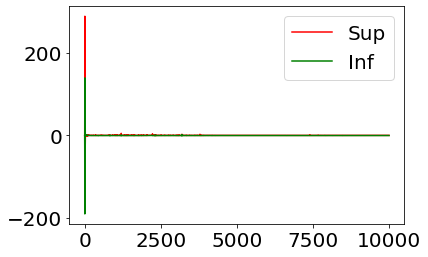

In [22]:
plt.plot(psi_l,'r', label='Sup')
plt.plot(ki_l,'g', label='Inf')
plt.legend()

In [23]:
plt.rcParams.update({'font.size': 30})

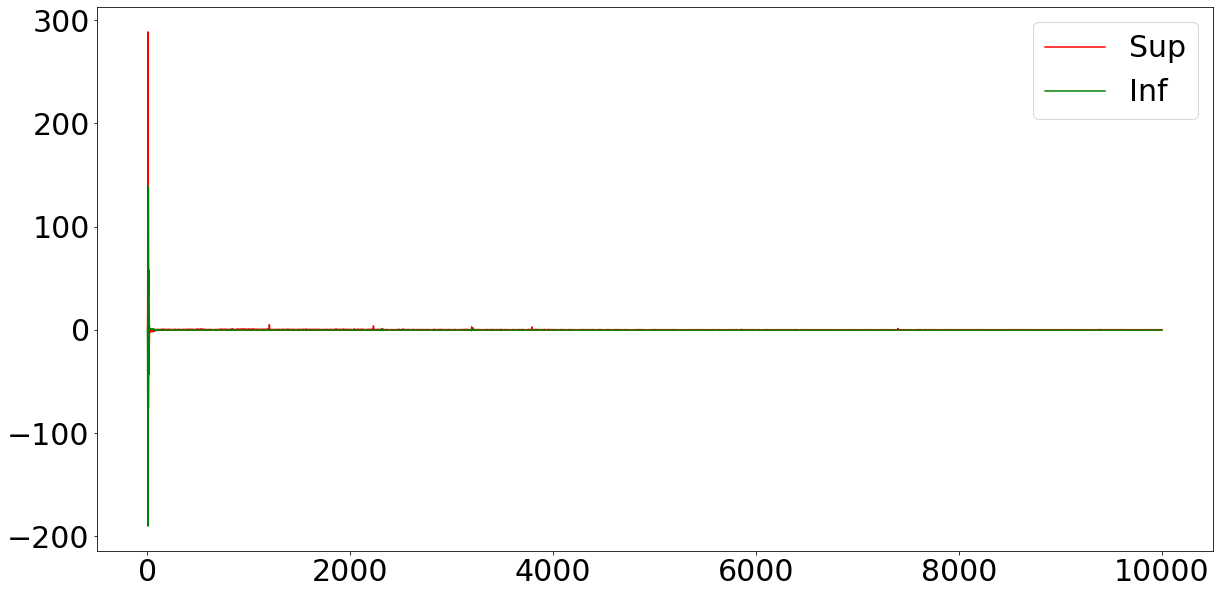

In [24]:
psi_l = np.asarray(psi_l)
ki_l = np.asarray(ki_l)

psi_l[psi_l>1e+3] = 1e+3
ki_l[ki_l>1e+3] = 1e+3

psi_l[psi_l<-1e+3] = -1e+3
ki_l[ki_l<-1e+3] = -1e+3

plt.figure(figsize=(20,10))
plt.plot(psi_l,'r', label='Sup')
plt.plot(ki_l,'g', label='Inf')
plt.legend()

plt.savefig('./output/Toy/OTM_Moon_training.jpg', bbox_inches='tight')


In [25]:
## Compute Transport plan
n = 200
indxs = random.sample(range(0,P.shape[0]), n)

y = torch.FloatTensor(P[indxs]).cuda()
x = torch.FloatTensor(Q[indxs]).cuda()
Tx = PushForward(ki,x)

x.shape, y.shape, Tx.shape

(torch.Size([200, 2]), torch.Size([200, 2]), torch.Size([200, 2]))

In [26]:
x = x.detach().cpu().numpy()
y = y.detach().cpu().numpy()
Tx = Tx.detach().cpu().numpy()
mu_t = Tx.mean(axis=0)

x.shape, y.shape, Tx.shape

((200, 2), (200, 2), (200, 2))

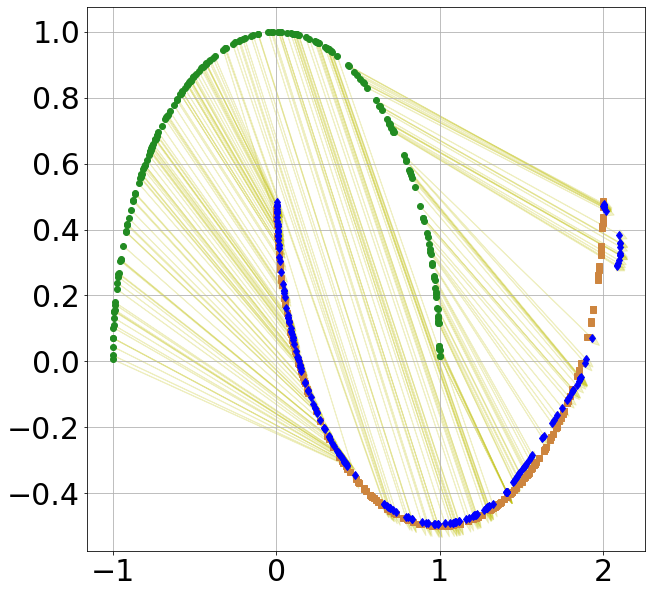

In [27]:
plt.figure(figsize=(10,10))
plt.plot(x[:,0],x[:,1],'og',label='Input (x)', color='forestgreen')
plt.plot(y[:,0],y[:,1],'s',label='Output (y)', color='peru')
plt.plot(Tx[:,0],Tx[:,1],'d',label='Transport (Tx)', color='blue')

for i in range(x.shape[0]):
    plt.arrow(x[i,0], x[i,1], Tx[i,0] - x[i,0], Tx[i,1] - x[i,1],  alpha=0.2, head_width=0.03, head_length = 0.05, fc='y', ec = 'y', color='y')

# plt.legend()
plt.grid()

plt.savefig('./output/Toy/OTM_Moon_grid.pdf', bbox_inches='tight')


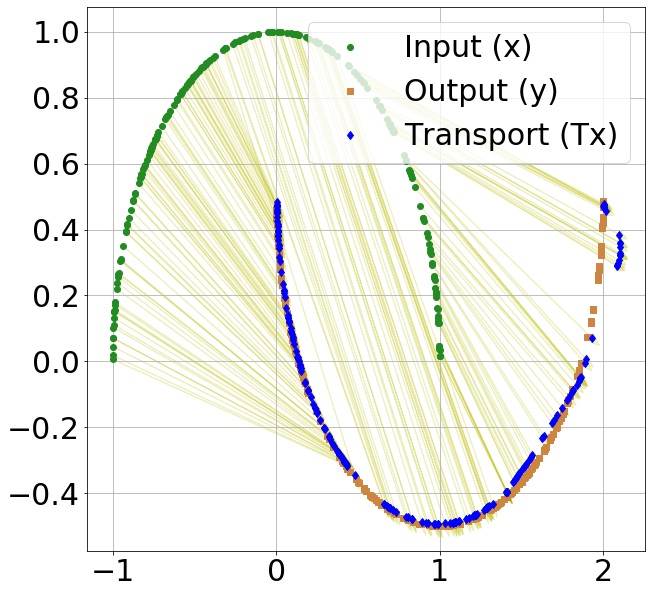

In [28]:
plt.figure(figsize=(10,10))
plt.plot(x[:,0],x[:,1],'og',label='Input (x)', color='forestgreen')
plt.plot(y[:,0],y[:,1],'s',label='Output (y)', color='peru')
plt.plot(Tx[:,0],Tx[:,1],'d',label='Transport (Tx)', color='blue')

for i in range(x.shape[0]):
    plt.arrow(x[i,0], x[i,1], Tx[i,0] - x[i,0], Tx[i,1] - x[i,1],  alpha=0.2, head_width=0.03, head_length = 0.05, fc='y', ec = 'y', color='y')

plt.legend()
plt.grid('off')

plt.savefig('./output/Toy/OTM_Moon.jpg', bbox_inches='tight')
